In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_log(log_path):
    data = pd.read_csv(log_path, header=None )
    header = "timestamp	event	version	tag".split("\t")
    data.columns = header
    data["timestamp"] = pd.to_datetime(data["timestamp"])

    return data


In [3]:
def match_events(data):
    data["key"] = data["event"].str.split(" ").apply(lambda x: " ".join(x[:-1]))

    start_times = data[data["event"].str.contains("start")]
    end_times = data[data["event"].str.contains("finished")]

    df_merged = start_times.merge(end_times, how="outer", on="key", suffixes=["", "_end"])

    start = df_merged.iloc[0]["timestamp"]

    # calculate relative start and end time
    df_merged["begin"] = (df_merged["timestamp"] - start).apply(lambda x: x.total_seconds())
    df_merged["end"] = (df_merged["timestamp_end"] - start).apply(
        lambda x: x.total_seconds()
    )

    # remove unneeded columns
    df_merged["event"] = df_merged["key"]
    df_merged["duration"] = df_merged["end"] - df_merged["begin"]
    df_merged.drop(
        columns=list(df_merged.filter(regex="_end")) + ["timestamp", "key"], inplace=True
    )
    return df_merged

In [4]:
def compare(log_a, log_b):
    native = read_log(log_a)
    mega = read_log(log_b)

    overhead = (match_events(mega).sum()["duration"] - match_events(native)["duration"]).item()
    return {"tag": mega["tag"][0], "overhead": overhead}

In [5]:
def get_data_size(log_path):
    data = read_log(file_b)
    data_size = data[data["event"].str.contains("data size")].event.str.split(":")[1][1]
    return data_size

In [25]:
import datetime
from pathlib import Path


files = list(sorted(Path("logs").glob("*.log")))

overheads = []

# date_cutoff = datetime.datetime(2024,1,18,17,20,0)
# date_cutoff = datetime.datetime(2024,1,22,0,0,0)
date_cutoff = datetime.datetime(2024,1,25,0,0,0)

for file_a, file_b in zip(files[::2], files[1::2]):
    if datetime.datetime.fromisoformat(file_a.stem) > date_cutoff:
        overhead = compare(file_a, file_b)
        overhead["data_size"] = get_data_size(file_b)
        overheads.append(overhead)

print(len(overheads))

3


<Axes: xlabel='data_size', ylabel='overhead'>

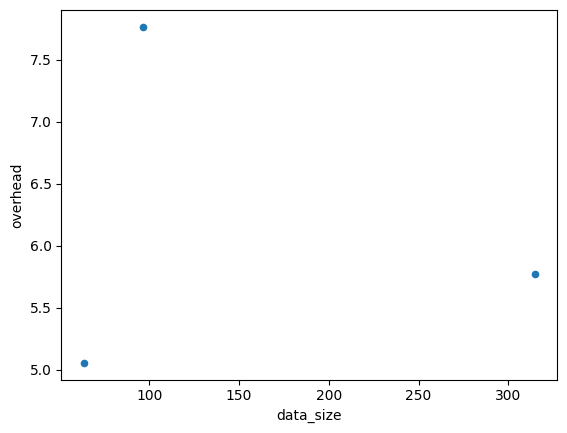

In [26]:
overheads = pd.DataFrame(overheads)
overheads["data_size"] = overheads["data_size"].astype(int) / 2**20
overheads.plot.scatter("data_size", "overhead")

mnist_remote                       Axes(0.1,0.15;0.235294x0.75)
resnet_18_fmnist              Axes(0.382353,0.15;0.235294x0.75)
roberta_finetune_local_cpu    Axes(0.664706,0.15;0.235294x0.75)
dtype: object

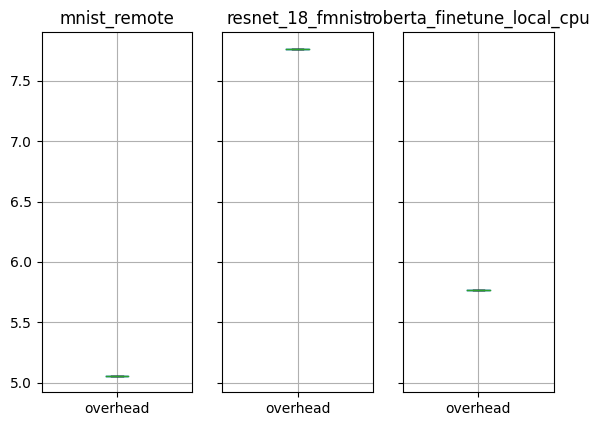

In [7]:
pd.DataFrame(overheads).groupby("tag").boxplot(layout=(1,3))

In [67]:
data_size

'100954523'

In [80]:
server_logs = list(sorted(Path("logs/server").glob("*.log")))
header = "timestamp	event	version	tag".split("\t")

server_data = pd.read_csv(server_logs[1], header=None)
server_data.columns = header

In [69]:
data = server_data
data["timestamp"] = pd.to_datetime(data["timestamp"])

df_merged = pd.concat([data, data.shift(-1).add_prefix("end_")], axis=1)
df_merged = df_merged.iloc[::2]
start = df_merged.iloc[0]["timestamp"]
df_merged["begin"] = (df_merged["timestamp"] - start).apply(lambda x: x.total_seconds())
df_merged["end"] = (df_merged["end_timestamp"] - start).apply(
    lambda x: x.total_seconds()
)
df_merged["event"] = df_merged["event"].apply(lambda x: " ".join(x.split(" ")[:-1]))
df_merged["duration"] = df_merged["end"] - df_merged["begin"]
df_merged.drop(
    columns=list(df_merged.filter(regex="end_")) + ["timestamp"], inplace=True
)
server_data = df_merged
server_data

,event,version,tag,begin,end,duration
0,recieving job,0.0.4,server,0.000,0.091,0.091
2,installing python,0.0.4,server,0.343,0.394,0.051
4,preparing venv,0.0.4,server,0.394,0.395,0.001
6,job execution,0.0.4,server,0.395,22.971,22.576


In [81]:

date_cutoff = datetime.datetime(2024,1,22,0,0,0)
files = list(sorted(Path("logs").glob("*.log")))
files = [f for f in files if datetime.datetime.fromisoformat(f.stem) > date_cutoff ]

data = pd.read_csv(files[1+2], header=None)
data.columns = header
data = pd.concat([server_data, data])

In [82]:


data["timestamp"] = pd.to_datetime(data["timestamp"])

df_merged = pd.concat([data, data.shift(-1).add_prefix("end_")], axis=1)
df_merged = df_merged.iloc[::2]

start = df_merged.sort_values("timestamp").iloc[0]["timestamp"]
df_merged["begin"] = (df_merged["timestamp"] - start).apply(lambda x: x.total_seconds())
df_merged["end"] = (df_merged["end_timestamp"] - start).apply(
    lambda x: x.total_seconds()
)
df_merged["event"] = df_merged["event"].apply(lambda x: " ".join(x.split(" ")[:-1]))
df_merged["duration"] = df_merged["end"] - df_merged["begin"]
df_merged.drop(
    columns=list(df_merged.filter(regex="end_")) + ["timestamp"], inplace=True
)

data = df_merged
data

,event,version,tag,begin,end,duration
0,recieving job,0.0.4,server,0.255508,0.346508,0.091000
2,installing python,0.0.4,server,0.598508,0.649508,0.051000
4,preparing venv,0.0.4,server,0.649508,0.650508,0.001000
6,job execution,0.0.4,server,0.650508,23.226508,22.576000
0,pickling,0.0.4,mnist_remote,0.000000,0.255019,0.255019
2,sending job,0.0.4,mnist_remote,0.255507,0.323749,0.068242
4,processing job,0.0.4,mnist_remote,0.756728,23.014305,22.257577
6,retrieving weights from remote,0.0.4,mnist_remote,23.014783,23.248924,0.234141
8,loading weights,0.0.4,mnist_remote,23.249015,23.920427,0.671412


In [66]:
data = pd.concat([data, server_data])

In [85]:
data.sort_values("begin")

,event,version,tag,begin,end,duration
0,pickling,0.0.4,mnist_remote,0.000000,0.255019,0.255019
2,sending job,0.0.4,mnist_remote,0.255507,0.323749,0.068242
0,recieving job,0.0.4,server,0.255508,0.346508,0.091000
2,installing python,0.0.4,server,0.598508,0.649508,0.051000
4,preparing venv,0.0.4,server,0.649508,0.650508,0.001000
6,job execution,0.0.4,server,0.650508,23.226508,22.576000
4,processing job,0.0.4,mnist_remote,0.756728,23.014305,22.257577
6,retrieving weights from remote,0.0.4,mnist_remote,23.014783,23.248924,0.234141
8,loading weights,0.0.4,mnist_remote,23.249015,23.920427,0.671412


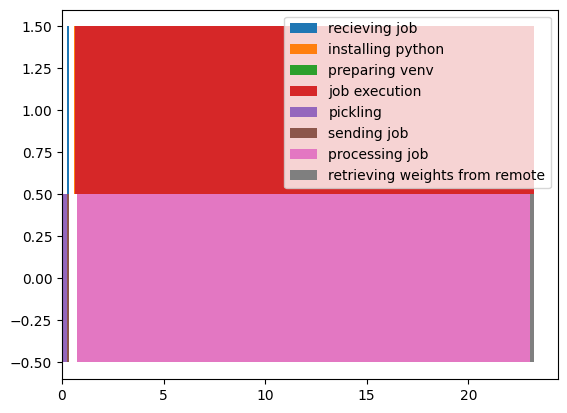

In [86]:
for index, row in data.iloc[:-1].iterrows():
    plt.barh(
        left=row["begin"], width=row["duration"], height=1, y=row["tag"]=="server", label=row["event"]
    )

plt.legend()

In [23]:
df_merged

,event,version,tag,begin,end,duration
0,pickling,0.0.4,roberta_finetune_local_cpu,0.000000,0.540238,0.540238
2,sending job,0.0.4,roberta_finetune_local_cpu,0.540859,0.945867,0.405008
4,processing job,0.0.4,roberta_finetune_local_cpu,2.032123,21.352272,19.320149
6,retrieving weights from remote,0.0.4,roberta_finetune_local_cpu,21.353038,22.888829,1.535791
8,loading weights,0.0.4,roberta_finetune_local_cpu,22.889061,23.907612,1.018551
0,recieving job,0.0.4,server,344094.477605,344094.996605,0.519000
2,installing python,0.0.4,server,344095.412605,344095.451605,0.039000
4,preparing venv,0.0.4,server,344095.451605,344346.897605,251.446000
6,job execution,0.0.4,server,344346.898605,344368.219605,21.321000
